# Generation and visualisation of the random dataset creation

In [16]:
import os
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import asyncio
import json
import nest_asyncio
nest_asyncio.apply()

from pubmetric.network import create_network 
from pubmetric.metrics import *
import random
import pubmetric.pckg_dev as dev
import pubmetric.workflow as wf

from style import palette, red_palette

##### Loading graph

In [11]:
path_to_data = '../out_20240801231111' 
loaded_graph = asyncio.run(create_network(inpath=path_to_data, load_graph=True))

2024-08-08 17:54:40 - Graph loaded from ../out_20240801231111


##### Testing that loading one Workflomics produced CWL workflow works
These have urls to containers, which is needed for the cwl_utils.parser function load_document_by_uri to work 

In [17]:
cwl_file_path = "../workflows/workflomics/candidate_workflow_23.cwl" # loading one of the APE generated workflows 
workflow = wf.parse_cwl(loaded_graph, cwl_file_path)

Generating a random workflow of the same structure. Each radnom tool is picked from a pool of tools with a siilar degree (using a range of +-50)

In [18]:
random_workflow = dev.generate_random_workflow(graph=loaded_graph, workflow=workflow)

Checking that they look the same 

In [19]:
print(json.dumps(workflow, indent=4)) # 
print(json.dumps(random_workflow, indent=4)) 

{
    "edges": [
        [
            "XTandem_01",
            "ProteinProphet_02"
        ],
        [
            "ProteinProphet_02",
            "StPeter_04"
        ],
        [
            "XTandem_03",
            "StPeter_04"
        ]
    ],
    "steps": {
        "ProteinProphet_02": "14632076",
        "StPeter_04": "29400476",
        "XTandem_01": "14976030",
        "XTandem_03": "14976030"
    },
    "pmid_edges": [
        [
            "14976030",
            "14632076"
        ],
        [
            "14632076",
            "29400476"
        ],
        [
            "14976030",
            "29400476"
        ]
    ]
}
{
    "edges": [
        [
            "UniProt_01",
            "MS-GFDB_02"
        ],
        [
            "MS-GFDB_02",
            "MassChroQ_04"
        ],
        [
            "UniProt_03",
            "MassChroQ_04"
        ]
    ],
    "steps": {
        "UniProt_01": "33237286",
        "MS-GFDB_02": "20829449",
        "MassChroQ_04": "2

##### Test that loading one APE generated workflow (without uri) works

In [20]:
cwl_file_path = "../workflows/APE/candidate_workflow_23.cwl" # loading one of the APE generated workflows 
undoc_workflow = wf.parse_undocumented_workflows(loaded_graph, cwl_file_path)
print(json.dumps(undoc_workflow, indent=4)) 

{
    "edges": [
        [
            "CrosstalkDB_01",
            "CrosstalkDB_02"
        ],
        [
            "CrosstalkDB_02",
            "MSiReader_03"
        ],
        [
            "MSiReader_03",
            "ComPIL_04"
        ],
        [
            "ComPIL_04",
            "isobar_05"
        ]
    ],
    "steps": {
        "CrosstalkDB_01": "24741113",
        "CrosstalkDB_02": "24741113",
        "MSiReader_03": "23536269",
        "ComPIL_04": "30525664",
        "isobar_05": "21526793"
    },
    "pmid_edges": [
        [
            "24741113",
            "24741113"
        ],
        [
            "24741113",
            "23536269"
        ],
        [
            "23536269",
            "30525664"
        ],
        [
            "30525664",
            "21526793"
        ]
    ]
}


#### Generating and saving a random dataset

The random dataset will be based on 1000 APE generated workflows in the proteomics domain. Out of these 1000 workflows, only the ones with at most one undefined pmid in the graph will be used. For each of these a randomly generated conterpart will be generated. 

In [37]:
# Because of a problem with the naming in APE the 8 and 9s are skipped, thus the id of the 1000th workflow is 1750. 
random_dataset = []
ape_tools = []
random_tools = []
completely_random_tools = []

ape_edges = []
random_edges = []
completely_random_edges = []

ape_worfklows = []

for i in range(1,1751):
    if '8' in str(i) or '9' in str(i):
        continue
    cwl_file_path = f"../workflows/APE/candidate_workflow_{i}.cwl" #
    workflow = wf.parse_undocumented_workflows(loaded_graph, cwl_file_path)

    if workflow['edges'] in ape_worfklows:
        print('Repetition')
        continue
    else:
        ape_worfklows.append(workflow['edges'])

    workflow_pmids = workflow['steps'].values()
    if len([pmid for pmid in workflow_pmids if not pmid]) <=1:
        random_workflow = dev.generate_random_workflow(graph=loaded_graph, workflow=workflow, random_seed=None)
        random_workflow_pmids = random_workflow['steps'].values()
        completely_random_workflow = dev.generate_random_workflow(graph=loaded_graph, workflow=workflow, retain_degree=False, tool_list=loaded_graph.vs['pmid'], random_seed=None)
        completely_random_workflow_pmids = completely_random_workflow['steps'].values()

        ape_tools += workflow_pmids
        random_tools += random_workflow_pmids
        completely_random_tools += completely_random_workflow_pmids        

        ape_edges += [(edge[0], edge[1]) for edge in workflow['edges']]
        random_edges += [(edge[0], edge[1]) for edge in random_workflow['edges']]
        completely_random_edges += [(edge[0], edge[1]) for edge in completely_random_workflow['edges']]
        

        # To save the dataset
        random_dataset.append( {
            'APE_workflow': workflow,
            'retained_degree_random_workflow': random_workflow,
            'completely_random_workflow': completely_random_workflow
        })


Repetition
Repetition
Repetition
Repetition


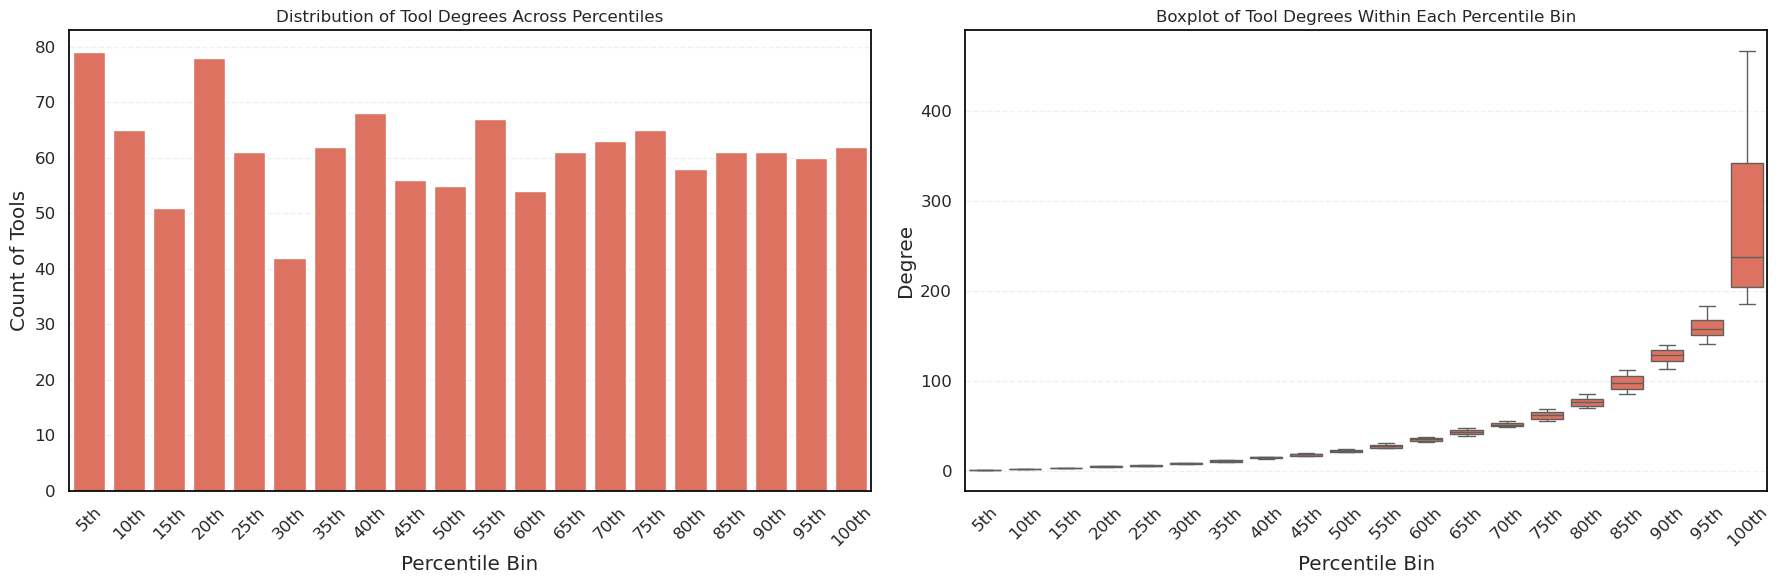

In [13]:
degrees = [vs.degree() for vs in loaded_graph.vs]

percentiles = np.percentile(degrees, np.arange(5, 105, 5))

# Function to assign degrees to percentile bins
def get_percentile_bin(degree, percentiles):
    for i, percentile in enumerate(percentiles):
        if degree <= percentile:
            return f'{i*5+5}th'
    return '100th'

# Assign each degree to a percentile bin
percentile_bins = [get_percentile_bin(degree, percentiles) for degree in degrees]

data = pd.DataFrame({
    'Degree': degrees,
    'Percentile Bin': percentile_bins
})

percentile_order = sorted(data['Percentile Bin'].unique(), key=lambda x: int(x.replace('th', '')))

data['Percentile Bin'] = pd.Categorical(data['Percentile Bin'], categories=percentile_order, ordered=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(x='Percentile Bin', data=data, order=percentile_order, ax=axes[0])
axes[0].set_title('Distribution of Tool Degrees Across Percentiles')
axes[0].set_xlabel('Percentile Bin')
axes[0].set_ylabel('Count of Tools')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='Percentile Bin', y='Degree', data=data, order=percentile_order, ax=axes[1])
axes[1].set_title('Boxplot of Tool Degrees Within Each Percentile Bin')
axes[1].set_xlabel('Percentile Bin')
axes[1].set_ylabel('Degree')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


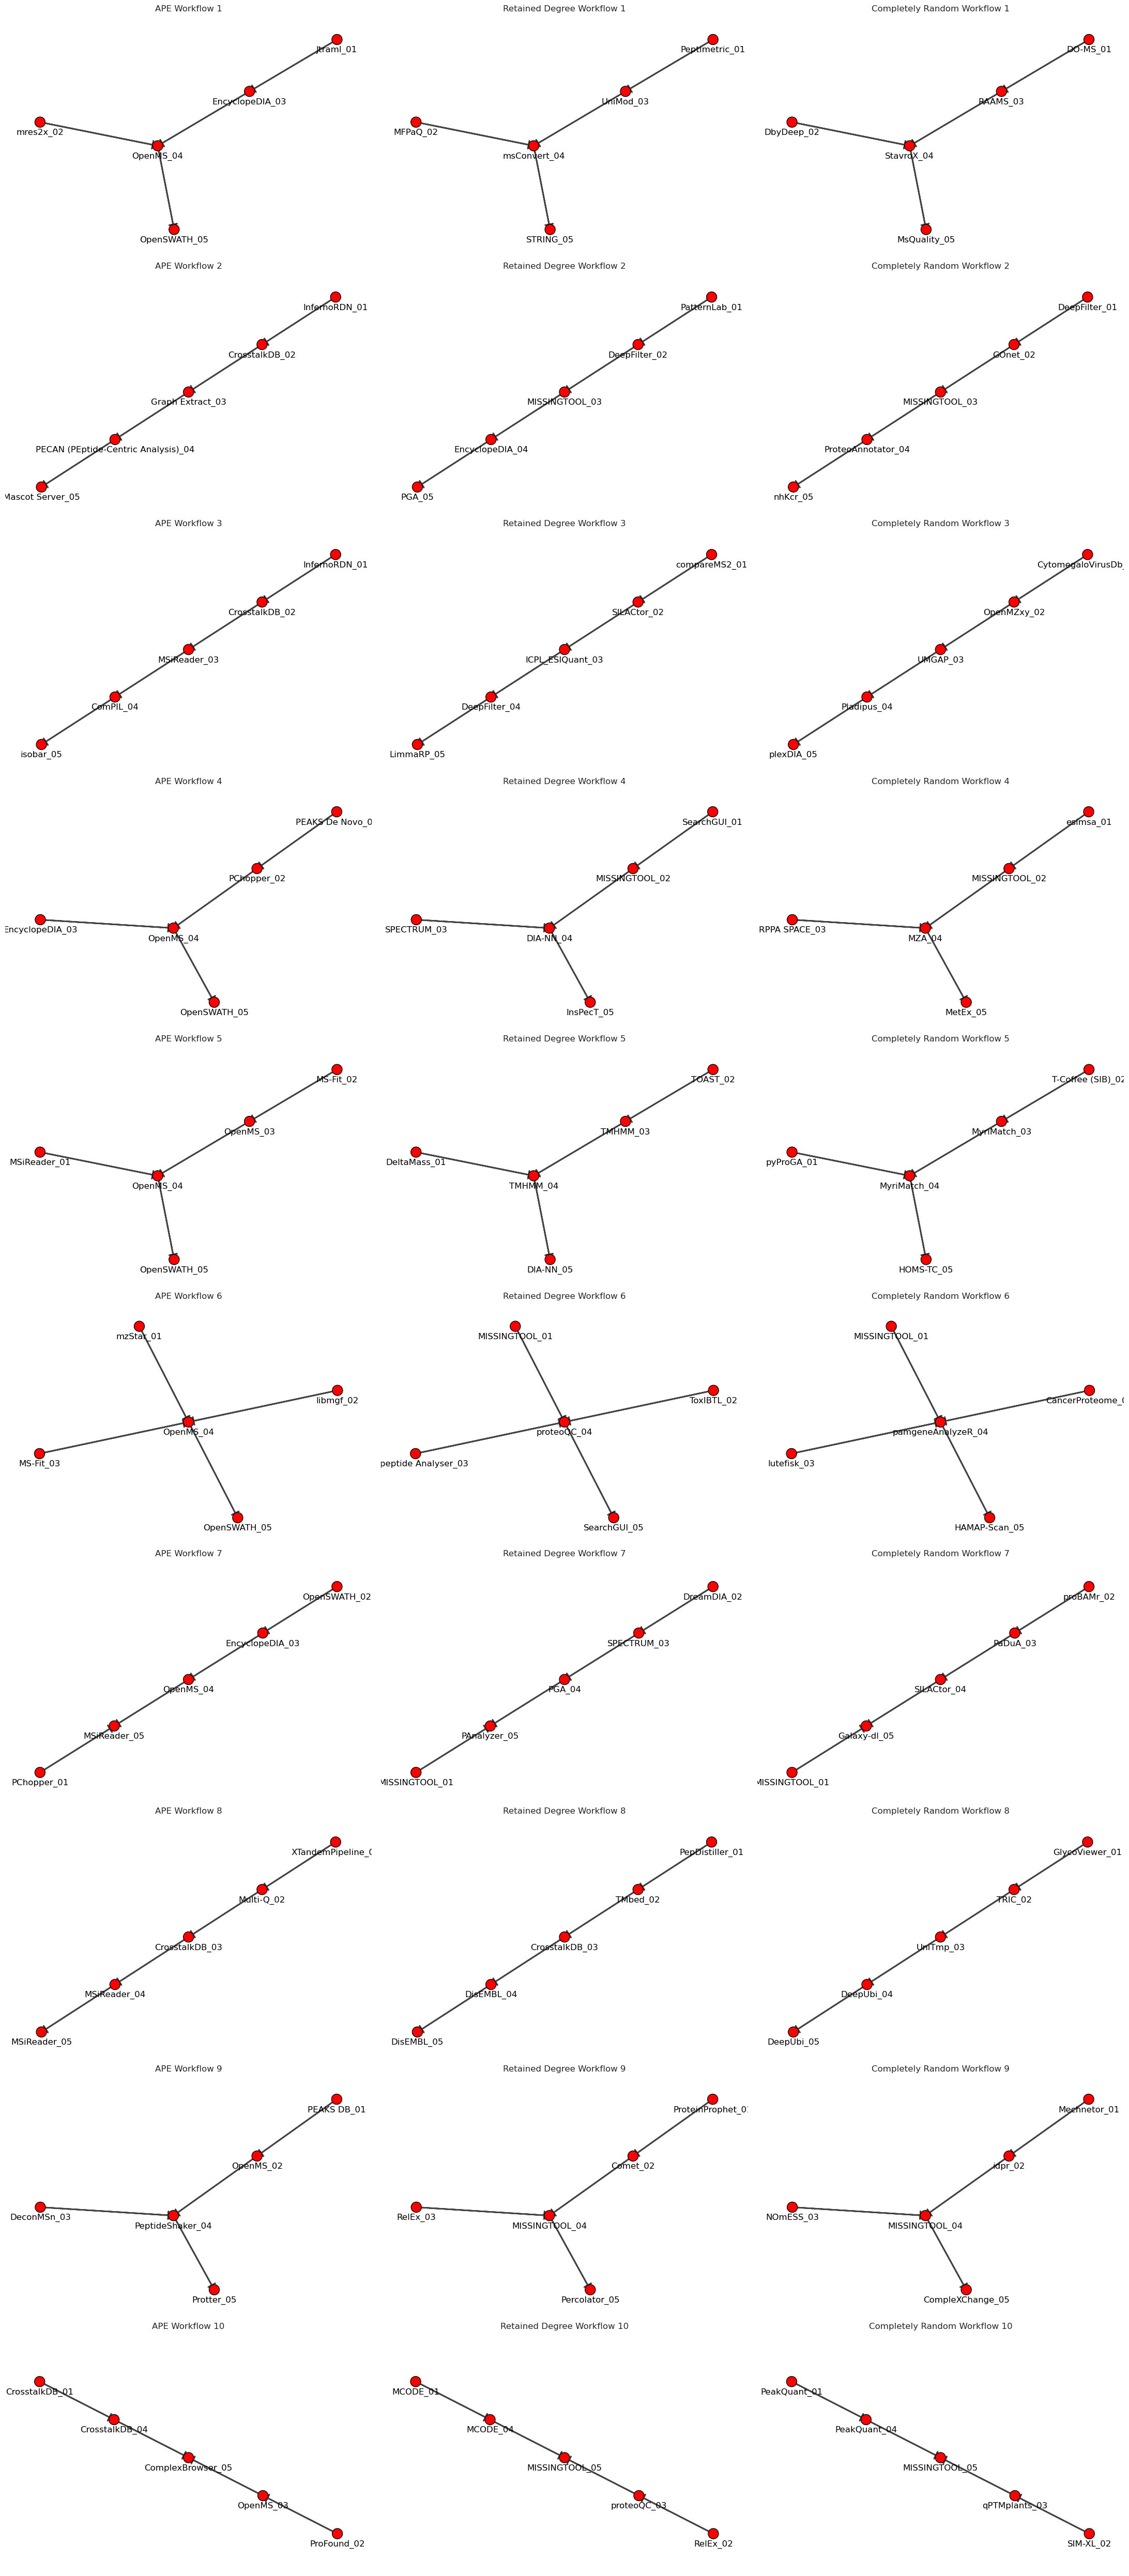

In [38]:
def plot_workflow_trios(random_dataset, num_trios=10):
    fig, axes = plt.subplots(num_trios, 3, figsize=(22, num_trios * 5))
    axes = axes.flatten()
    selected_trios = random.sample(random_dataset, num_trios)

    for i, trio in enumerate(selected_trios):
        ape_edges = dev.convert_to_tuples(trio['APE_workflow']['edges'])
        retained_degree_edges = dev.convert_to_tuples(trio['retained_degree_random_workflow']['edges'])
        completely_random_edges = dev.convert_to_tuples(trio['completely_random_workflow']['edges'])

        ape_graph = igraph.Graph.TupleList(edges=ape_edges, directed=True)
        retained_degree_graph = igraph.Graph.TupleList(edges=retained_degree_edges, directed=True)
        completely_random_graph = igraph.Graph.TupleList(edges=completely_random_edges, directed=True)

        layout = ape_graph.layout("kk")
        axes[3*i].clear()
        igraph.plot(ape_graph, layout=layout, target=axes[3*i],
                    vertex_label=ape_graph.vs['name'],
                    vertex_label_dist=1.5,
                    vertex_size=20,
                    edge_arrow_size=0.5)
        axes[3*i].set_title(f'APE Workflow {i+1}')

        layout = retained_degree_graph.layout("kk")
        axes[3*i+1].clear()
        igraph.plot(retained_degree_graph, layout=layout, target=axes[3*i+1],
                    vertex_label=retained_degree_graph.vs['name'],
                    vertex_label_dist=1.5,
                    vertex_size=20,
                    edge_arrow_size=0.5)
        axes[3*i+1].set_title(f'Retained Degree Workflow {i+1}')

        layout = completely_random_graph.layout("kk")
        axes[3*i+2].clear()
        igraph.plot(completely_random_graph, layout=layout, target=axes[3*i+2],
                    vertex_label=completely_random_graph.vs['name'],
                    vertex_label_dist=1.5,
                    vertex_size=20,
                    edge_arrow_size=0.5)
        axes[3*i+2].set_title(f'Completely Random Workflow {i+1}')

    plt.tight_layout()
    plt.show()

plot_workflow_trios(random_dataset)


In [39]:
unique_ape_tools = np.unique([t for t in ape_tools if t])
unique_random_tools = np.unique([t for t in random_tools if t])
unique_completely_random_tools = np.unique([t for t in completely_random_tools if t])


unique_ape_edges = np.unique([t for t in ape_edges if t])
unique_random_edges = np.unique([t for t in random_edges if t])
unique_completely_random_edges = np.unique([t for t in completely_random_edges if t])

Saving the dataset

In [41]:
with open("../data/random_dataset.json", 'w') as f:
    json.dump(random_dataset, f)

Stats on the random data set

In [40]:
print(len(random_dataset))

print(len(unique_ape_tools))
print(len(unique_random_tools))
print(len(unique_completely_random_tools))

print(len(unique_ape_edges))
print(len(unique_random_edges))
print(len(unique_completely_random_edges))

669
96
591
1103
286
1317
2281
